(128, 128)


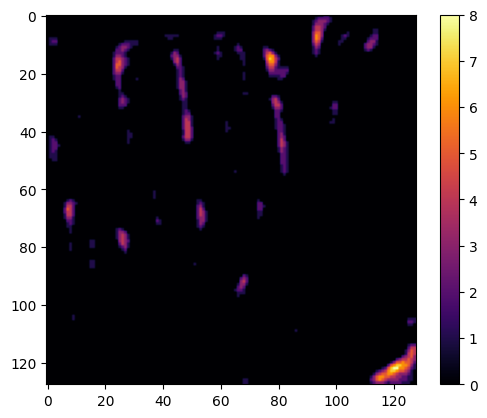

In [28]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

image=Image.open(Path('./data/test_dataset/predicted/DEU_09_20_3_1_BAM_OUT.png'))
image_array=np.asarray(image)
print(image_array.shape)
# Plot the image with colormap
plt.imshow(np.asarray(image), cmap='inferno')  # Use the 'gray' colormap for grayscale images
plt.colorbar()  # Add a colorbar to show the mapping of pixel values to colors
plt.show()


In [4]:
import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm

def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)

idx=0
mask_suffix='_AGL'
img_suffix='_BAM'
dir_img = Path('./data/imgs/')
dir_mask = Path('./data/masks/')
images_dir = Path(dir_img)
mask_dir = Path(dir_mask)

In [7]:
ids = [splitext(file)[0].rsplit('_', 1)[0] for file in listdir(images_dir) if isfile(join(images_dir, file)) and not file.startswith('.')]
if not ids:
    raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')

name = ids[idx]
mask_file = list(mask_dir.glob(name + mask_suffix + '.*'))
img_file = list(images_dir.glob(name + img_suffix +  '.*'))

assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'


print(len(img_file))
print(len(mask_file))

mask = load_image(mask_file[0])
img = load_image(img_file[0])
    
assert img.size == mask.size, \
    f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

print(img.size)
print(mask.size)

img_ar = np.asarray(img)
print(img_ar.size)
print(img_ar.shape)
print(img_ar.ndim)


img_ar = np.asarray(mask)
print(img_ar.size)
print(img_ar.shape)
print(img_ar.ndim)

1
1
(256, 256)
(256, 256)
262144
(256, 256, 4)
3
65536
(256, 256)
2


In [12]:
img_trs=img_ar.transpose((2, 0, 1))
img_trs[:3, :, :]

array([[[ 74,  74,  67, ...,  80,  80,  74],
        [ 64,  64,  60, ..., 103, 103,  94],
        [ 48,  48,  51, ..., 119, 119, 115],
        ...,
        [ 42,  42,  34, ..., 107, 107, 113],
        [ 57,  57,  49, ..., 139, 139, 130],
        [ 74,  74,  72, ..., 167, 167, 142]],

       [[ 73,  73,  68, ...,  73,  73,  70],
        [ 65,  65,  63, ...,  92,  92,  87],
        [ 55,  55,  56, ..., 106, 106, 104],
        ...,
        [ 45,  45,  36, ...,  98,  98, 104],
        [ 55,  55,  48, ..., 124, 124, 119],
        [ 68,  68,  65, ..., 147, 147, 128]],

       [[ 45,  45,  41, ...,  46,  46,  45],
        [ 39,  39,  35, ...,  65,  65,  63],
        [ 28,  28,  29, ...,  77,  77,  77],
        ...,
        [ 24,  24,  17, ...,  72,  72,  80],
        [ 32,  32,  25, ..., 100, 100,  94],
        [ 44,  44,  39, ..., 120, 120, 100]]], dtype=uint8)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
input = torch.randn(3, 3)
target = torch.randn(3, 3)

# Create a batch tensor with tensors of 1s, 2s, and 5s
batch_tensor1 = torch.stack([torch.ones((3, 3)), torch.full((3, 3), 2), torch.full((3, 3), 5)])

# Create another batch tensor with tensors of 11s, 12s, and 15s
batch_tensor2 = torch.stack([torch.full((3, 3), 11), torch.full((3, 3), 12), torch.full((3, 3), 15)])


mae_loss = nn.L1Loss()
output = F.l1_loss(batch_tensor1, batch_tensor2,reduction='none')
#output.backward()

print('input: ', batch_tensor1)
print('target: ', batch_tensor2)
print('output: ', output)

input:  tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        [[5., 5., 5.],
         [5., 5., 5.],
         [5., 5., 5.]]])
target:  tensor([[[11, 11, 11],
         [11, 11, 11],
         [11, 11, 11]],

        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],

        [[15, 15, 15],
         [15, 15, 15],
         [15, 15, 15]]])
output:  tensor([[[10., 10., 10.],
         [10., 10., 10.],
         [10., 10., 10.]],

        [[10., 10., 10.],
         [10., 10., 10.],
         [10., 10., 10.]],

        [[10., 10., 10.],
         [10., 10., 10.],
         [10., 10., 10.]]])


In [11]:

from PIL import Image
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
import numpy as np

def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)
    
def preprocess(pil_img, scale, is_mask):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img = np.asarray(pil_img)

        if is_mask:
            mask=img[np.newaxis, :, :]
            return mask

        else:
            if img.ndim == 2:
                img = img[np.newaxis, ...]
            else:
                img = img.transpose((2, 0, 1))
                img = img[:3, :, :]

            if (img > 1).any():
                img = img / 1

            return img
        
img = load_image(Path('./data/imgs/BEL_01_05_4_4_BAM.tif'))
img = preprocess(img, 1, is_mask=False)
img
        


C:\Users\luism\AppData\Local\Temp\ipykernel_7660\3658009299.py:20: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)


array([[[187., 187., 175., ..., 159., 165., 164.],
        [184., 184., 192., ..., 162., 168., 166.],
        [184., 184., 192., ..., 162., 168., 166.],
        ...,
        [249., 249., 236., ..., 116., 113., 116.],
        [250., 250., 231., ..., 118., 112., 116.],
        [250., 250., 231., ..., 118., 112., 116.]],

       [[163., 163., 155., ..., 132., 138., 138.],
        [160., 160., 170., ..., 136., 140., 139.],
        [160., 160., 170., ..., 136., 140., 139.],
        ...,
        [230., 230., 210., ...,  96.,  94.,  96.],
        [227., 227., 204., ...,  96.,  92.,  96.],
        [227., 227., 204., ...,  96.,  92.,  96.]],

       [[132., 132., 125., ..., 104., 111., 112.],
        [133., 133., 143., ..., 106., 112., 112.],
        [133., 133., 143., ..., 106., 112., 112.],
        ...,
        [198., 198., 178., ...,  66.,  64.,  66.],
        [191., 191., 169., ...,  67.,  62.,  65.],
        [191., 191., 169., ...,  67.,  62.,  65.]]])

In [42]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np

import wandb
from evaluate import evaluate
from unet import UNet
from utils.data_loading import BasicDataset, CarvanaDataset
from utils.dice_score import dice_loss
from utils.weighting import calculate_weights, weights_tensor

dir_img = Path('./data/train_dataset/imgs/')
dir_mask = Path('./data/train_dataset/masks/')
dir_checkpoint = Path('./checkpoints/')    

# 1. Create dataset
try:
    dataset = CarvanaDataset(dir_img, dir_mask, 1)
except (AssertionError, RuntimeError, IndexError):
    dataset = BasicDataset(dir_img, dir_mask, 1)

# 2. Split into train / validation partitions
n_val = int(len(dataset) * 0.1)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

# 3. Create data loaders
loader_args = dict(batch_size=1, pin_memory=True) #, num_workers=os.cpu_count()
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)


all_height_values = []

# Collect from train_loader
for batch in train_loader:
    for mask in batch['mask']:
        all_height_values.extend(mask.flatten())

# Collect from val_loader
for batch in val_loader:
    for mask in batch['mask']:
        all_height_values.extend(mask.flatten())

# Convert to NumPy array
all_height_values = np.array(all_height_values)

# 4. Calculate and plot histogram with 1-meter bins
bin_width = 1

# Create the histogram
hist, bins = np.histogram(all_height_values, bins=np.arange(int(all_height_values.min()), int(all_height_values.max()) + 2, bin_width))

# Normalize the histogram
normalized_hist = hist / hist.sum()

# Calculate weights inversely proportional to the normalized values
weights = np.zeros_like(normalized_hist)
non_zero_indices = normalized_hist != 0
weights[non_zero_indices] = 1 / normalized_hist[non_zero_indices]

100%|██████████| 60/60 [00:19<00:00,  3.05it/s]


In [44]:
import pandas as pd
# Create a DataFrame for histogram and weights
data = {'Bin_Edges': bins[:-1], 'Histogram': normalized_hist, 'Weights': weights}
df_weights = pd.DataFrame(data)

df_weights.to_csv('wei.csv')
df_weights

,Bin_Edges,Histogram,Weights
0,-4,2.543132e-07,3.932160e+06
1,-3,1.118978e-05,8.936727e+04
2,-2,3.026326e-05,3.304336e+04
3,-1,5.289714e-05,1.890462e+04
4,0,6.312464e-01,1.584167e+00
...,...,...,...
63,59,0.000000e+00,0.000000e+00
64,60,0.000000e+00,0.000000e+00
65,61,0.000000e+00,0.000000e+00
66,62,2.543132e-07,3.932160e+06


In [45]:
# Create an iterator for the DataLoader
data_iter = iter(train_loader)

# Get the first batch
first_batch = next(data_iter)

heights_tensor=first_batch['mask']
weights_df=df_weights
# Flatten the tensor and concatenate batches
flattened_heights = heights_tensor.view(-1)

# Get the bin edges and weights from the DataFrame
bin_edges = weights_df['Bin_Edges'].values
weights = np.asarray(weights_df['Weights'].values)

# Convert NumPy array to PyTorch tensor
bin_edges_tensor = torch.tensor(bin_edges, dtype=torch.float32)

# Identify the corresponding weights for each height value
indices = torch.bucketize(flattened_heights, bin_edges_tensor)
weights_tensor = torch.from_numpy(weights[indices])

# Reshape the tensor back to its original shape
weights_tensor=weights_tensor.view(heights_tensor.shape)
